In [1]:
from settings import *
from q_channel_approx.physics_defns import default_jump_operators, no_decay_jump_operators
from q_channel_approx import TriangularLayoutA, HEA_fac

##### Set global constants for this experiment

In [2]:
delta_t = 0.5
N = 1
L = 10


##### Load observables

In [3]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [4]:
rho0s = random_rho0s(m=m, L=L)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

random_rho0s: setting seed=1716


##### Create a qubit layout and a parametrized circuit on those qubits

In [5]:
qubits = TriangularLayoutA(m=m, distance=0.9)
circuit = HEA_fac(qubits, depth=10, repeats=1)

<Axes: title={'center': 'Qubit layout'}>

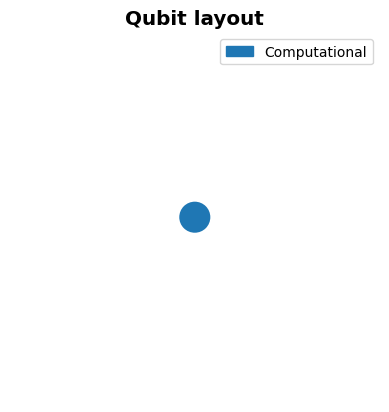

In [6]:
qubits.show_layout()

In [7]:
# optionally load already optimized theta

# theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [8]:
theta_opt, errors, thetas = optimize(
    circuit=circuit, 
    training_data=training_data, 
    n_grad=10, 
    max_count=100,
)

# optionally, save the results of the optimization process

# theta_opt = np.save("ham_theta_opt.npy", theta_opt)
# thetas = np.save("ham_thetas.npy", thetas)
# errors = np.save("ham_errors.npy", errors)

optimizer (optimization indices): setting seed=99830


C:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


small sigma
Zero gradient hit after 38 iterations


Text(0, 0.5, 'error')

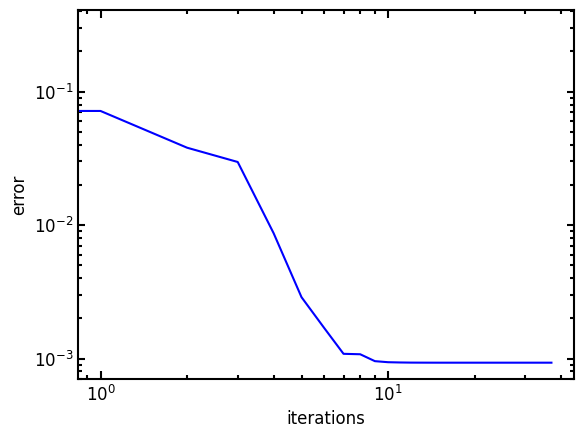

In [9]:
plt.loglog(errors)
plt.xlabel("iterations")
plt.ylabel("error")

##### Compare approximated Hamiltonian to the actual Hamiltonian

In [10]:
eH_approx = circuit(theta_opt)
eH_ref = sc.linalg.expm((-1j) * delta_t * create_hamiltonian(system).full())

In [11]:
eH_approx

array([[-0.9808782 -3.74191129e-05j,  0.01115318+1.94302780e-01j],
       [-0.01115318+1.94302780e-01j, -0.9808782 +3.74191129e-05j]])

In [12]:
eH_ref

array([[0.98006658+0.j        , 0.        -0.19866933j],
       [0.        -0.19866933j, 0.98006658+0.j        ]])

In [13]:
eH_ref - eH_approx

array([[ 1.96094477+3.74191129e-05j, -0.01115318-3.92972111e-01j],
       [ 0.01115318-3.92972111e-01j,  1.96094477-3.74191129e-05j]])

##### Plot approximated solution compared to reference solution

In [14]:
n_time_steps = 200
Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

In [15]:
rho0 = rho_rand_haar(m=m)

rho_rand_haar: seed=12902


In [16]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

In [17]:
# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())